# RadarCOVID-Report

In [73]:
import matplotlib
import pandas as pd
import seaborn as sns

%matplotlib inline

sns.set()
matplotlib.rcParams['figure.figsize'] = (15, 6)

## COVID-19 Cases

In [74]:
confirmed_df = pd.read_csv("https://covid19tracking.narrativa.com/csv/confirmed.csv")
confirmed_df = confirmed_df[confirmed_df["Country_EN"] == "Spain"]
confirmed_df = confirmed_df[pd.isna(confirmed_df["Region"])]
confirmed_df.drop(columns=["Country_EN", "Country_ES", "Country_IT", "Region"], inplace=True)
confirmed_df = confirmed_df.transpose()
confirmed_df.reset_index(inplace=True)
confirmed_df.columns = ["sample_date_string", "cumulative_cases"]
confirmed_df["new_cases"] = confirmed_df.cumulative_cases.diff()
confirmed_df["rolling_mean_new_cases"] = confirmed_df.new_cases.rolling(7).mean()
confirmed_df.head()

,sample_date_string,cumulative_cases,new_cases,rolling_mean_new_cases
0,2020-01-23,0.0,NaN,NaN
1,2020-01-24,0.0,0.0,NaN
2,2020-01-25,0.0,0.0,NaN
3,2020-01-26,0.0,0.0,NaN
4,2020-01-27,0.0,0.0,NaN


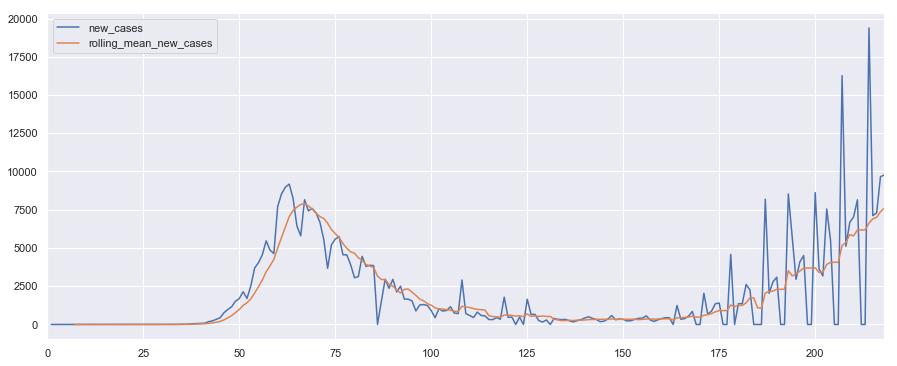

In [75]:
confirmed_df[["new_cases", "rolling_mean_new_cases"]].plot()

## RadarCOVID TEKs Extraction

In [76]:
import radar_covid_core

exposure_keys_df = radar_covid_core.download_last_radar_covid_exposure_keys()
exposure_keys_summary_df = \
    exposure_keys_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "tek_count"}, inplace=True)

# We should expect 14 TEKs (one per sample day) for infected devices but the real value may be lower:
exposure_keys_summary_df["approximate_tek_devices"] = exposure_keys_summary_df.tek_count / 14.0

exposure_keys_summary_df.head()

INFO:root:Downloading exposed tokens for day '2020-08-29' from 'https://radarcovid.covid19.gob.es/dp3t/v1/gaen/exposed/1598659200000'...
INFO:root:Downloading exposed tokens for day '2020-08-28' from 'https://radarcovid.covid19.gob.es/dp3t/v1/gaen/exposed/1598572800000'...
INFO:root:Exposure Key File 'RadarCOVID-2020-08-28'
Timestamp Range: 1598572800 -> 1598580000
Region: ES

Signature Details:
Verification Key Version: V1
Verification Key ID: 214
Signature Algorithm: 1.2.840.10045.4.3.2

Exposure Keys (19):
fde71eb8-4416-01de-cfe9-14e3cd45ca38 (rolling start interval number: 2664288, rolling period: 144, transmission risk level: 0)
4b427ea1-6d5f-43cd-cdc0-e7b6f6b11939 (rolling start interval number: 2664288, rolling period: 144, transmission risk level: 0)
fdd5e4de-175c-00a1-5546-bf3348cf2fa3 (rolling start interval number: 2664288, rolling period: 144, transmission risk level: 0)
aab121c3-a2e8-4f66-ecb9-1389e986dd2c (rolling start interval number: 2664288, rolling period: 144, trans

INFO:root:Downloading exposed tokens for day '2020-08-26' from 'https://radarcovid.covid19.gob.es/dp3t/v1/gaen/exposed/1598400000000'...
INFO:root:Exposure Key File 'RadarCOVID-2020-08-26'
Timestamp Range: 1598400000 -> 1598407200
Region: ES

Signature Details:
Verification Key Version: V1
Verification Key ID: 214
Signature Algorithm: 1.2.840.10045.4.3.2

Exposure Keys (58):
641f2ad8-4693-559a-e884-1077ecd3c222 (rolling start interval number: 2664000, rolling period: 144, transmission risk level: 0)
1fd61ec2-6f5c-d400-64d6-064231dd1f31 (rolling start interval number: 2664000, rolling period: 144, transmission risk level: 0)
2e758387-7b8c-a1cd-6ab5-7566f6dce6b9 (rolling start interval number: 2664000, rolling period: 144, transmission risk level: 0)
c370f048-701c-e316-f6ee-eff0ffb4a6b1 (rolling start interval number: 2664000, rolling period: 144, transmission risk level: 0)
c487c9ec-c27b-d0a0-e642-2a39697a7471 (rolling start interval number: 2664000, rolling period: 144, transmission ri

INFO:root:Downloading exposed tokens for day '2020-08-24' from 'https://radarcovid.covid19.gob.es/dp3t/v1/gaen/exposed/1598227200000'...
INFO:root:Exposure Key File 'RadarCOVID-2020-08-24'
Timestamp Range: 1598227200 -> 1598234400
Region: ES

Signature Details:
Verification Key Version: V1
Verification Key ID: 214
Signature Algorithm: 1.2.840.10045.4.3.2

Exposure Keys (41):
92ce3ac2-0fab-c266-133b-1cfbfa00b36c (rolling start interval number: 2663712, rolling period: 144, transmission risk level: 0)
4cc4405d-352c-28ad-0a78-e1d5d6a41886 (rolling start interval number: 2663712, rolling period: 144, transmission risk level: 0)
2599bac9-85d2-2274-8a62-a18c1e3aba76 (rolling start interval number: 2663712, rolling period: 144, transmission risk level: 0)
5b4b38d5-9293-9ea0-4622-d61b32940afc (rolling start interval number: 2663712, rolling period: 144, transmission risk level: 0)
7540702e-32dd-a136-b4f8-3edaa2e4e02e (rolling start interval number: 2663712, rolling period: 144, transmission ri

INFO:root:Downloading exposed tokens for day '2020-08-22' from 'https://radarcovid.covid19.gob.es/dp3t/v1/gaen/exposed/1598054400000'...
INFO:root:Exposure Key File 'RadarCOVID-2020-08-22'
Timestamp Range: 1598054400 -> 1598061600
Region: ES

Signature Details:
Verification Key Version: V1
Verification Key ID: 214
Signature Algorithm: 1.2.840.10045.4.3.2

Exposure Keys (18):
316fcc1d-9bdb-69ae-b997-70b5b4ca1d74 (rolling start interval number: 2663424, rolling period: 144, transmission risk level: 0)
33b23da9-a420-ac28-fec2-c498f4ad6804 (rolling start interval number: 2663424, rolling period: 144, transmission risk level: 0)
ebfd298d-8779-87f6-2aa0-50e5260d846b (rolling start interval number: 2663424, rolling period: 144, transmission risk level: 0)
4d9266e6-7e09-3c04-9587-c7661053b436 (rolling start interval number: 2663424, rolling period: 144, transmission risk level: 0)
ce45fe24-4423-a8fd-0e05-00bbb756ccb7 (rolling start interval number: 2663424, rolling period: 144, transmission ri

,tek_count,approximate_tek_devices
sample_date_string,,
2020-08-28,19,1.357143
2020-08-27,45,3.214286
2020-08-26,58,4.142857
2020-08-25,48,3.428571
2020-08-24,41,2.928571


In [77]:
exposure_keys_summary_df = exposure_keys_summary_df.merge(confirmed_df, on=["sample_date_string"], how="inner")
exposure_keys_summary_df["tek_count_per_case"] = \
    exposure_keys_summary_df.tek_count / exposure_keys_summary_df.rolling_mean_new_cases
exposure_keys_summary_df["approximate_tek_devices_per_case"] = \
    exposure_keys_summary_df.approximate_tek_devices / exposure_keys_summary_df.rolling_mean_new_cases
exposure_keys_summary_df.head()

,sample_date_string,tek_count,approximate_tek_devices,cumulative_cases,new_cases,rolling_mean_new_cases,tek_count_per_case,approximate_tek_devices_per_case
0,2020-08-28,19,1.357143,439286.0,9779.0,7604.571429,0.002498,0.000178
1,2020-08-27,45,3.214286,429507.0,9658.0,7371.571429,0.006105,0.000436
2,2020-08-26,58,4.142857,419849.0,7296.0,6997.428571,0.008289,0.000592
3,2020-08-25,48,3.428571,412553.0,7117.0,6908.142857,0.006948,0.000496
4,2020-08-24,41,2.928571,405436.0,19382.0,6622.000000,0.006191,0.000442


In [ ]:
exposure_keys_summary_df["sample_date"] = pd.to_datetime(exposure_keys_summary_df.sample_date_string)
exposure_keys_summary_df.set_index("sample_date", inplace=True)

## Results

In [88]:
exposure_keys_summary_df[[
    "tek_count",
    "approximate_tek_devices",
    "new_cases",
    "rolling_mean_new_cases",
    "tek_count_per_case",
    "approximate_tek_devices_per_case"]].head()

,tek_count,approximate_tek_devices,new_cases,rolling_mean_new_cases,tek_count_per_case,approximate_tek_devices_per_case
sample_date,,,,,,
2020-08-28,19,1.357143,9779.0,7604.571429,0.002498,0.000178
2020-08-27,45,3.214286,9658.0,7371.571429,0.006105,0.000436
2020-08-26,58,4.142857,7296.0,6997.428571,0.008289,0.000592
2020-08-25,48,3.428571,7117.0,6908.142857,0.006948,0.000496
2020-08-24,41,2.928571,19382.0,6622.000000,0.006191,0.000442


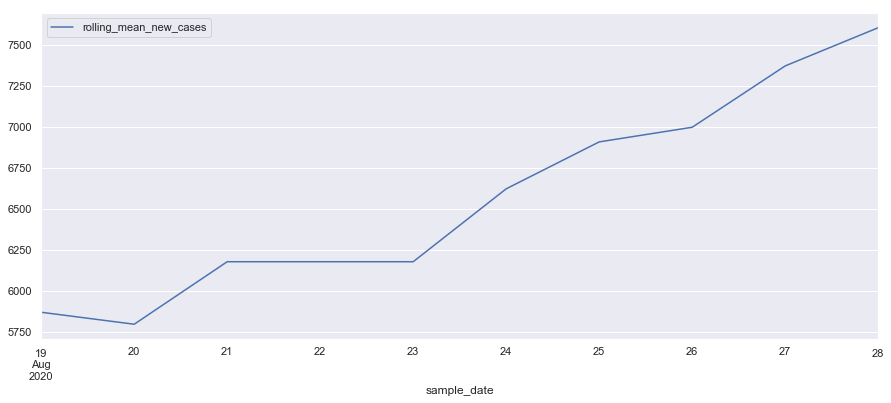

In [89]:
exposure_keys_summary_df[["rolling_mean_new_cases"]].plot()

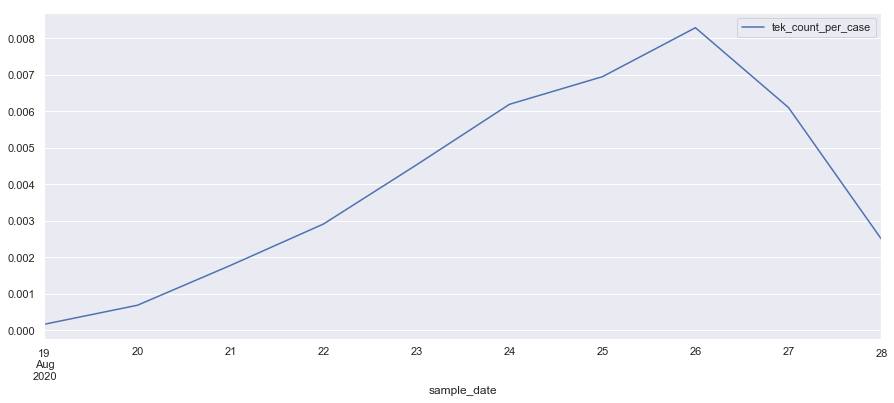

In [90]:
exposure_keys_summary_df[["tek_count_per_case"]].plot()

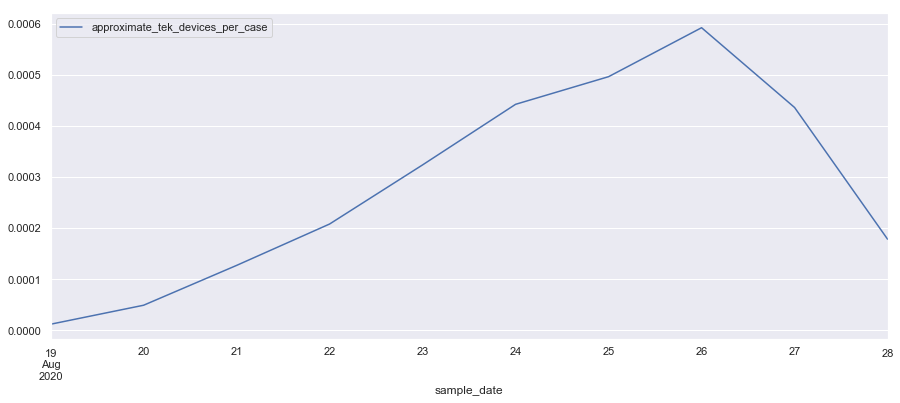

In [91]:
exposure_keys_summary_df[["approximate_tek_devices_per_case"]].plot()